In [40]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from importlib import reload 
import torch
import fasttext
from ptb import lang_util
import torch
from torch.nn import CrossEntropyLoss, NLLLoss
import numpy as np

In [31]:
import rsm_samplers
import rsm
from ptb import lang_util
import rsm_experiment
reload(rsm_samplers)
reload(rsm)
reload(lang_util)
reload(rsm_experiment)

CONFIG = {
    'debug': False,
    'path': "/Users/jgordon/nta/results",
    'data_dir': "/Users/jgordon/nta/datasets",
    'dataset': 'ptb',
    'predictor_hidden_size': 1200,
    'predictor_output_size': 10000,
    'batch_size': 300,
    'batches_in_epoch': 2000,
    'batches_in_first_epoch': 2,
    'batch_log_interval': 2000,
    'vocab_size': 10000,
    'eval_interval': 3,
    'eval_batch_size': 100,
    'eval_batches_in_epoch': 824, #8243,
    'learning_rate': 0.0005,
    'm_groups': 1500,
    'n_cells_per_group': 1,
    'k_winners': 80,
    'k_winner_cells': 1,
    'pred_l2_reg': 0.000001,
    'dec_l2_reg': 0.000001,
    'input_bias': True,
    'eval_interval': 5,
    'eps': 0.5,
    'gamma': 0.0,
    'forget_mu': 0.025,
    'weight_sparsity': None,
    'mult_integration': False,
    'fpartition': None,
    'boost_strength': 0.5,
    'boost_strength_factor': 0.85,
    'boost_strat': 'col_boosting',
    'do_inhibition': False,
    'x_b_norm': True,
    'balance_part_winners': True,
    'decode_activation_fn': None,
    'decode_bias': False,
    'embed_dim': 100,
    'input_size': (1, 100),
    'output_size': 100,
    'embedding_kind': 'ptb_fasttext_e5',
    'max_decay': 0.95,
    'mem_floor': 0.0005,
    'trainable_decay': True,
    'word_cache_decay': 0.99
}

## Adj RSM entropy

In [41]:
import math

def max_entropy(n, k):
    """The maximum entropy we could get with n units and k winners."""
    s = float(k) / n
    if 0.0 < s < 1.0:
        entropy = -s * math.log(s, 2) - (1 - s) * math.log(1 - s, 2)
    else:
        entropy = 0

    return n * entropy

def binary_entropy(x):
    """Calculate entropy for a list of binary random variables.

    :param x: (torch tensor) the probability of the variable to be 1.
    :return: entropy: (torch tensor) entropy, sum(entropy)
    """
    entropy = -x * x.log2() - (1 - x) * (1 - x).log2()
    entropy[x * (1 - x) == 0] = 0
    return entropy, entropy.sum()

def update_duty_cycle(duty_cycle, learning_iterations, x):
    batch_size = x.shape[0]
    learning_iterations += batch_size
    period = min(1000, learning_iterations)
    duty_cycle.mul_(period - batch_size)
    duty_cycle.add_(x.gt(0).sum(dim=0, dtype=torch.float))
    duty_cycle.div_(period)

def forward_and_get_entropy(exp, loader, bsz):
    exp.model.train() 
    tc = exp.m_groups * exp.n_cells_per_group
    k = exp.k_winners
    duty_cycle = torch.zeros(tc)
    learning_iterations = 0
    with torch.no_grad():
        hidden = exp._init_hidden(bsz)
        for _b_idx, (inputs, targets, pred_targets, input_labels) in enumerate(loader):
            inputs = inputs.to(exp.device)
            targets = targets.to(exp.device)
            pred_targets = pred_targets.to(exp.device)
            input_labels = input_labels.to(exp.device)

            output, hidden = exp.model(inputs, hidden)
            
            update_duty_cycle(duty_cycle, learning_iterations, exp.model.RSM_1.col_winners.squeeze())
    
    _, ent = binary_entropy(duty_cycle)
    max_ent = max_entropy(tc, k)
    
#     e = exp.model.RSM_1.kwinners_col.entropy()
#     max_e = exp.model.RSM_1.kwinners_col.max_entropy()
    print("Adj RSM: entropy / max entropy: %.3f/%.3f" % (ent, max_e))
    return ent

In [55]:
# Load bRSM
exp = rsm_experiment.RSMExperiment(config=CONFIG)
exp.model_setup(CONFIG, restore_path="/Users/jgordon/Desktop/rsm_highlights/PTB/RSMTune_0_2019-09-20_21-15-18mchjovgl/checkpoint_112")

print("Train...")
e_boost_train = forward_and_get_entropy(exp, exp.train_loader, 300)
print("Test...")
e_boost_test = forward_and_get_entropy(exp, exp.val_loader, 100)

setup: Using cpu
Maybe download PTB...


Loaded embedding dict (ptb_fasttext_e5) with 10000 entries
Built dataloaders...
Loading from /Users/jgordon/Desktop/rsm_highlights/PTB/RSMTune_0_2019-09-20_21-15-18mchjovgl/checkpoint_112
Train...
Adj RSM: entropy / max entropy: 365.110/450.587
Test...
Adj RSM: entropy / max entropy: 371.547/450.587


In [48]:
# Load inhibited RSM
exp = rsm_experiment.RSMExperiment(config=CONFIG)
exp.model_setup(CONFIG, restore_path="/Users/jgordon/Desktop/rsm_highlights/PTB/Ablation/Flat_PTB_Abl_Inh/RSMTune_0_2019-09-22_22-35-225sg3eimn/checkpoint_102")

print("Train...")
e_inh_train = forward_and_get_entropy(exp, exp.train_loader, 300)
print("Test...")
e_inh_test = forward_and_get_entropy(exp, exp.val_loader, 100)


setup: Using cpu
Maybe download PTB...


Loaded embedding dict (ptb_fasttext_e5) with 10000 entries
Built dataloaders...
Loading from /Users/jgordon/Desktop/rsm_highlights/PTB/Ablation/Flat_PTB_Abl_Inh/RSMTune_0_2019-09-22_22-35-225sg3eimn/checkpoint_102
Train...
Adj RSM: entropy / max entropy: 422.524/450.587
Test...
Adj RSM: entropy / max entropy: 418.565/450.587


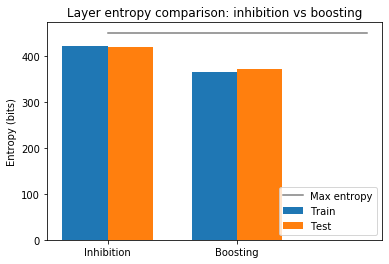

In [56]:
import matplotlib.pyplot as plt

MAX_ENT = 450.6


labels = ['Inhibition', 'Boosting']
inh_entropies = [e_inh_train.item(), e_boost_train.item()]
boost_entropies = [e_inh_test.item(), e_boost_test.item()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, inh_entropies, width, label='Train')
rects2 = ax.bar(x + width/2, boost_entropies, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Entropy (bits)')
ax.set_title('Layer entropy comparison: inhibition vs boosting')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.plot([0, 2], [MAX_ENT, MAX_ENT], c='gray', label="Max entropy")
ax.legend()